Importação das bibliotecas que serão necessárias.

Aqui fazemos a instalação (import) de pacotes (package) do Python que serão necessários ao longo do notebook.

### pyproj (biblioteca para mudança do sistema de coordenadas)
Para instalar o pyproj rode a célula abaixo

In [1]:
!python -m pip install pyproj

### tqdm (biblioteca para mostrar barras de progresso)
Para instalar o tqdm rode a célula abaixo

In [2]:
!python -m pip install tqdm

In [3]:
import matplotlib.pyplot as plt

import shutil

from datetime import datetime

import json

import numpy as np

from pyproj import Proj, transform

# Carregando o arquivo de dados do KartaView

Vamos agora analisar os dados coletados através da plataforma KartaView.

Esses dados estão formatados usando-se o formato JSON de JavaScript Object Notation.

Um arquivo JSON é um arquivo de texto com uma mensagem estruturada com o formato JSON.

In [4]:
# Vamos carregar os pontos (do JSON filtrado) na variável pontos.
arquivo_pontos = "cleaned_sample2.json"

with open(arquivo_pontos, "r") as f:
    pontos = f.read()
    pontos = json.loads(pontos)



# Medindo distâncias

## Funções auxiliares

Para facilitar a escrita do código e terminarmos com código adequado ao problema que queremos resolver, ao invés de nos preocuparmos com
detalhes da estrutura interna dos dados, vamos definir aqui algumas funções auxiliares com a responsabilidade exclusiva de coletar uma propriedade específica da lista de pontos, possivelmente tratando o dado coletado.



### def get_point_coords(index, points_object)

Essa função irá nos auxiliar para coletar as coordenadas (e.g. longitude e latitude) de um ponto (na posição 'index') da lista de pontos passado também como parâmetro da função.

Note que as coordenadas dos pontos (no arquivo de dados) usam a projeção EPSG:4326, isso significa que estas coordenadas são angulos e portanto precisamos fazer uma conversão, ou mais precisamente uma (re)projeção em um outro sistema de coordenadas (i.e. CRS) que use unidades métricas (e.g. metros).

In [5]:
def get_point_coords(index, points_object):
    """
    Essa função recebe um índice numérico correspondendo a uma
    posição na lista de pontos "points_object".
    
    Ela retorna um vetor do numpy com a longitude e latitude
    (propriedades 'lng' e 'lat') do ponto na posição 'index'.
    """
    lat = points_object[index]['lat']
    lat = float(lat)
    lng = points_object[index]['lng']
    lng = float(lng)
    return np.array((lng, lat))


### def get_point_coords_proj(index, points_object)

Essa função auxiliar faz exatamente o mesmo que a anterior, contudo os pontos aqui são reprojetados para a projeção EPSG:3857, que usa como unidade métrica o 'metro' ao invés de graus de ângulo.

In [6]:
def get_point_coords_proj(index, points_object):
    """
    Essa função é similar a get_point_coords, ela 
    recebe um índice numérico correspondendo a uma
    posição na lista de pontos "points_object".
    
    Contudo esta os pontos na projeção EPSG:3857 em
    que a unidade de medida é em metros e portanto
    podemos calcular a distância euclidiana entre dois
    pontos com base em suas coordenadas.
    
    Os pontos retornados são um vetor numpy em que
    a primeira posição é uma medida em metros no eixo
    horizontal e a segunda é num eixo vertical.
    O ponto de origem pode ser visto aqui https://epsg.io/3857
    """
    
    lat = points_object[index]['lat']
    lat = float(lat)
    lng = points_object[index]['lng']
    lng = float(lng)
    p = np.array((lng, lat))
    p = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), p[0], p[1])
    return p

### def get_shot_time(index, points_object)

Esta função é um acessor para a propriedade 'shot_date' na lista de pontos. Essa propriedade indica o momento (dia e hora incluindo segundos) em que o ponto foi criado.

In [7]:
FMT = '%Y-%m-%d %H:%M:%S'
def get_shot_time(index, points_object):
    """
    Retorna a data e hora em que o ponto 'index',
    da lista de pontos 'points_object', foi criado.
    
    O formato de retorno é uma string '%Y-%m-%d %H:%M:%S'
    (e.g. 2018-03-03 20:55:32)
    """
    t = points_object[index]['shot_date']
    t = datetime.strptime(t, FMT)
    return t

In [8]:
def get_points_in_time_interval(min_sec, max_sec, points_object):
    selected_points = []
    for i in range(len(points_object)):
        point = points_object[i]
        if point['tempo_decorrido'] < min_sec:
            continue
        if point['tempo_decorrido'] > max_sec:
            break
        selected_points.append(point)
    return selected_points
            
            

In [9]:
def distancia_euclidiana(v1, v2):
    """
    Tendo como parâmetros os vetores numpy 2D 'v1' e 'v2', crie uma
    função que retorne a distância euclidiana entre os dois vetores.
    """
    return np.sqrt(np.sum((v1-v2)**2))

# Modelagem e predições

Vamos amostrar agora um trecho do trajeto e com base nesta amostra vamos calcular a velocidade média ao longo do trajeto principal, em várias partes do trajeto. Além disso também vamos tentar predizer com este modelo qual a posição do veículo (i.e. distância percorrida ao longo do trajeto) em instantes de tempo que não foram amostrados.

## Exercício 1 - Distância e tempo decorrido até um ponto dado

A projeção de coordenadas esféricas para o plano cartesiano é uma operação computacionalmente demorada. Assim, executamos previamente a projeção das coordenadas do sistema de coordenadas EPSG:4326 (coordenadas esféricas) para o sistema de coordenadas EPSG:3857 (com coordenadas no plano cartesiano e unidades em metros). As coordenadas convertidas foram armazenadas no próprio arquivo json com os pontos de cada foto. As novas propriedades se chamam `easting` indicando em metros a posição da foto no eixo horizontal e `northing` indicando também em metros a posição da foto no eixo vertical.

O código abaixo ilustra como estas propriedades foram calculadas e como foram inseridas no arquivo json dos dados (i.e. `cleaned_sample2.json`):

```
from tqdm.auto import tqdm
for i in tqdm(range(len(pontos))):
    if pontos[i].get('easting') is not None:
        continue
    easting, northing = get_point_coords_proj(i, pontos)
    pontos[i]['easting'] = easting
    pontos[i]['northing'] = northing

with open('cleaned_sample2.json', 'w+') as f:
    json.dump(pontos, f, indent=2)
```

Exercício 1A - Usando o arquivo `cleaned_sample2.json` você deve calcular a distância percorrida desde o ínicio do trajeto escolhido até um ponto atual dado (em metros) usando as novas propriedades `easting` e `northing`. Assuma que a distância percorrida até o início do trajeto (primeiro ponto) é zero.

Exercício 1B - Você também deve calcular o tempo decorrido (em segundos) desde o ínicio do trajeto escolhido até o ponto atual dado.

Exercício 1C - Insira os valores calculados como novas propriedades dos pontos chamadas `distancia_percorrida` e `tempo_decorrido` (em segundos) e salve essa nova coleção de pontos num novo arquivo json chamado `cleaned_sample3.json`.

In [10]:
def distancia_tempo(tfim,pontos):  
    d = 0
    t = 0 
    tinicio = 0
    info = []   
    while(tinicio < tfim):
        pp1 = np.array((float(pontos[tinicio]['easting']),float(pontos[tinicio]['northing'])))
        pp2 = np.array((float(pontos[tinicio+1]['easting']),float(pontos[tinicio+1]['northing'])))
        d = d + distancia_euclidiana(pp1,pp2) 
        t = t + (get_shot_time(tinicio+1, pontos) - get_shot_time(tinicio, pontos)).seconds
        pontos[tinicio]['tempo_decorrido'] = t
        pontos[tinicio]['distancia_percorrida'] = d 
        info.append(pontos[tinicio])
        tinicio += 1
    cleaned_sample3(pontos)
    return info

def cleaned_sample3(pontos):   
    f = open('cleaned_sample3.json', "w")
    json.dump(pontos, f, indent=2)


In [11]:
# Dica, para pegar e calcular a diferença de tempo entre dois pontos você pode usar a função get_shot_time:
tdelta = get_shot_time(1, pontos)-get_shot_time(0, pontos)
print(f"A diferença entre dois objetos 'datetime' gera um objeto 'timedelta': {type(tdelta)}")
print(f"Exemplo do objeto 'timedelta': {tdelta}")
print(f'Segundos decorridos: {tdelta.seconds}')

A diferença entre dois objetos 'datetime' gera um objeto 'timedelta': <class 'datetime.timedelta'>
Exemplo do objeto 'timedelta': 0:00:07
Segundos decorridos: 7


Se tudo der certo, um ponto no ínicio do trajeto (índice baixo) vai ser parecido com o abaixo:


`pontos[3]`

```
{'lat': '32.188302',
 'lng': '-81.195051',
 'heading': '124.32529',
 'shot_date': '2018-03-03 20:29:53',
 'easting': -9038591.73225388,
 'northing': 3788053.65048532,
 'tempo_decorrido': 17,
 'distancia_percorrida': 30.770423073027203}
```

e um ponto mais pro meio do trajeto vai parecer com algo assim:

`pontos[1000]`

```
{'lat': '32.450081',
 'lng': '-80.991726',
 'heading': '57.014393',
 'shot_date': '2018-03-03 20:53:26',
 'easting': -9015957.696788337,
 'northing': 3822536.8402403975,
 'tempo_decorrido': 1430,
 'distancia_percorrida': 43456.56002203702}
```

## Selecionando um intervalo para análise do movimento

Assumindo que o vetor de pontos (i.e. `pontos`) agora contém objetos com as propriedades `distancia_percorrida` e `tempo_decorrido` podemos usar estas novas propriedades para analisar o movimento.

Como exemplo, selecionamos um intervalo que irá conter pontos que ocorrem após `tinicio` segundos e antes de  `tfim` segundos após o ínicio do percurso. Esses pontos foram escolhidos pois correspondem a um trecho de estrada que parece-se com uma reta.

In [12]:
tinicio = 3000
tfim = 3180
pontos = distancia_tempo(len(pontos)-1,pontos)
pontos_intervalo = get_points_in_time_interval(tinicio, tfim, pontos)
print(f"Número de pontos no intervalo: {len(pontos_intervalo)}") 
print(f"Instante inicial do intervalo: {pontos_intervalo[0]['tempo_decorrido']} segundos")
print(f"Instante final do intervalo: {pontos_intervalo[-1]['tempo_decorrido']} segundos")

Número de pontos no intervalo: 127
Instante inicial do intervalo: 3000 segundos
Instante final do intervalo: 3180 segundos


In [13]:
# Os pontos abaixos foram selecionados de forma que entre cada um deles se passam exatamente 18 segundos.
sample_points = [pontos_intervalo[i] for i in [0, 13, 25, 38, 51, 64, 76, 89, 101, 113, 126]]

print(f"Número de pontos amostrados: {len(sample_points)}")

Número de pontos amostrados: 11


## Exercício 2. Usando os pontos selecionados acima, calcule a velocidade média em cada trecho e compare com a velocidade média no trecho todo (tinicio=3000 até tfim=3180). 

Para organizar melhor seu trabalho para os próximos exercícios, crie três vetores:
- tempos - vetor com a lista dos tempo em que cada ponto foi alcançado
- distancias - vetor com a lista das distâncias acumuladas em cada trecho (entre cada um ponto e outro). 
- velocidades - vetor com a lista de velocidades médias em cada trecho.

In [14]:
tempos = [sample_points[i]['tempo_decorrido']for i in range(len(sample_points))]
distancias = [sample_points[i]['distancia_percorrida']for i in range(len(sample_points))]
velocidades = []
for el in range(len(sample_points)):
    velocidades.append(distancias[el]/tempos[el])
print(f'Velocidades: {velocidades}')

Velocidades: [27.049708724288678, 27.090985641562416, 27.131168108981328, 27.17141331235005, 27.213211962117267, 27.252822712902148, 27.29369606218685, 27.33243547997429, 27.372138920647025, 27.40937810193232, 27.44589329994134]


### Visualização das amostras - O código abaixo serve para você visualizar a posição do carro em função do tempo.

In [15]:
def plot_dist_time(dist_vec, time_vec, marker='.', **kwargs):
    fig, ax = plt.subplots(1, **kwargs)
    #fig, ax = plt.subplots(1, figsize=(16,8))
    ax.scatter(time_vec, dist_vec, marker=marker)
    ax.set_xlabel('tempo decorrido (s)', fontsize=14);
    ax.set_ylabel('distância percorrida (m)', fontsize=14);
    return fig, ax

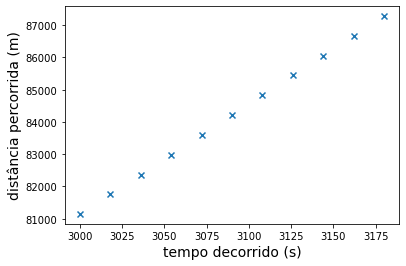

In [16]:
fig, ax = plot_dist_time(distancias, tempos, marker='x')
#plt.scatter(tempos, distancias, marker='x')
#plt.xlabel('tempo (s)')
#plt.ylabel('distância (m)')

## Exercício 3. Faça agora um gráfico das velocidades médias calculadas.


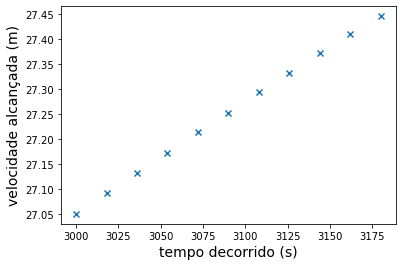

In [17]:
def plot_vec_time(vec,time, marker='.', **kwargs):
    fig, ax = plt.subplots(1, **kwargs)
    ax.scatter(time,vec, marker=marker)
    ax.set_xlabel('tempo decorrido (s)', fontsize=14);
    ax.set_ylabel('velocidade alcançada (m)', fontsize=14);
    return fig, ax

fig, ax = plot_vec_time(velocidades, tempos, marker='x')
    

## Exercício 4. Faça o mesmo para o trajeto completo, isto é, do primeiro ponto até o último ponto do arquivo cleaned_sample3.json.

Se você fez o gráfico corretamente, você verá três trechos em que a velocidade é aproximadamente constante. 

## Exercício 5. Calcule a velocidade média em cada trecho em que a velocidade é aproximadamente constante.

## Exercício 6. Tente explicar em palavras o que acontece nas descontinuidades do gráfico.



Velocidade média trecho 1: 34.060405845223144 m/s; Velocidade média trecho 2: 33.89744824153721 m/s; Velocidade média trecho 3: 34.05456067823048 m/s


'\nA descontinuidade no gráfico ocorre pois não tem fotos dessa parte da trajetória, \nou seja sem fotos não há metadados a serem extraidos ou representados.\n'

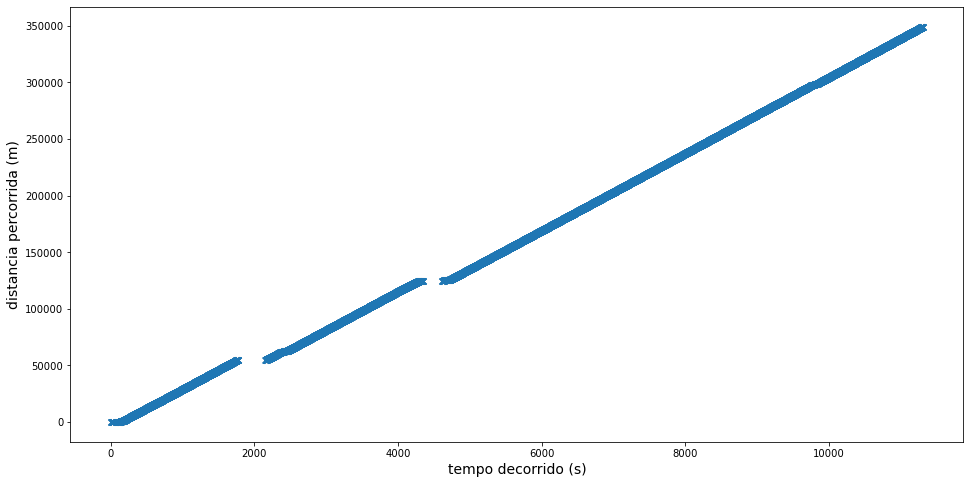

In [18]:
#Exercícios 4

tempos = [pontos[i]['tempo_decorrido']for i in range(len(pontos))]
distancias = [pontos[i]['distancia_percorrida']for i in range(len(pontos))]
velocidades = []
for el in range(len(pontos)):
    v = distancias[el] / tempos[el]
    velocidades.append(v)
#print(f'Velocidades: {velocidades}')

#Exercícios 5
trecho1 = get_points_in_time_interval(1000, 1150, pontos)
trecho2 = get_points_in_time_interval(3850, 4000, pontos)
trecho3 = get_points_in_time_interval(6000, 6150, pontos)
vec_1 = (trecho1[-1]['distancia_percorrida']-trecho1[0]['distancia_percorrida']) / (trecho1[-1]['tempo_decorrido']-trecho1[0]['tempo_decorrido'])
vec_2 = (trecho2[-1]['distancia_percorrida']-trecho2[0]['distancia_percorrida']) / (trecho2[-1]['tempo_decorrido']-trecho2[0]['tempo_decorrido'])
vec_3 = (trecho3[-1]['distancia_percorrida']-trecho3[0]['distancia_percorrida']) / (trecho3[-1]['tempo_decorrido']-trecho3[0]['tempo_decorrido'])
print(f'Velocidade média trecho 1: {vec_1} m/s; Velocidade média trecho 2: {vec_2} m/s; Velocidade média trecho 3: {vec_3} m/s')

def plot_total(dist,time, marker='.'):
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.scatter(time,dist, marker=marker)
    ax.set_xlabel('tempo decorrido (s)', fontsize=14);
    ax.set_ylabel('distancia percorrida (m)', fontsize=14);
    return fig, ax

fig, ax = plot_total(distancias, tempos, marker='x')

#Exercício 6

"""
A descontinuidade no gráfico ocorre pois não tem fotos dessa parte da trajetória, 
ou seja sem fotos não há metadados a serem extraidos ou representados.
"""

## Exercício 7. Usando as velocidades médias calculadas no exercício 5, estabeleça uma posição inicial para cada trecho e calcule a posição do veículo para 50 pontos de acordo com o modelo de movimento uniforme e compare, medindo o erro entre a posição calculada e a posição observada do veículo. Faça um gráfico da dispersão dos erros para cada trecho. 

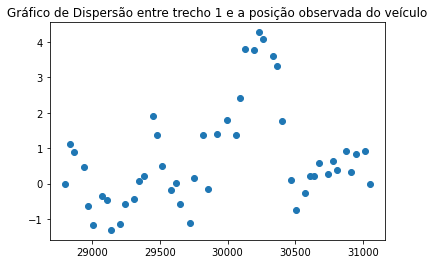

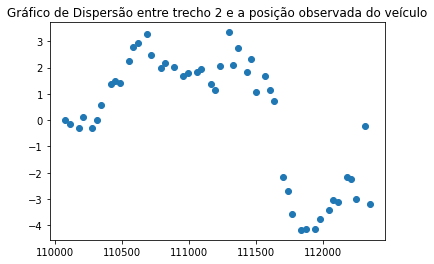

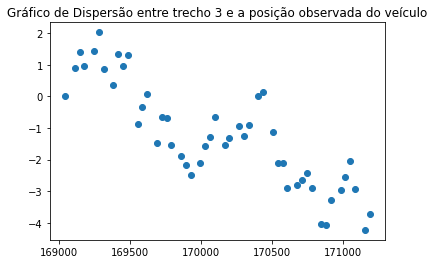

In [19]:
from matplotlib import pyplot

#Exercício 7
dp1 = []
dp2 = []
dp3 = []
for i in range(0,49):
    s1 = trecho1[0]['distancia_percorrida'] + (vec_1 *(trecho1[i]['tempo_decorrido']-trecho1[0]['tempo_decorrido']))
    s2 = trecho2[0]['distancia_percorrida'] + (vec_2 *(trecho2[i]['tempo_decorrido']-trecho2[0]['tempo_decorrido']))
    s3 = trecho3[0]['distancia_percorrida'] + (vec_3 *(trecho3[i]['tempo_decorrido']-trecho3[0]['tempo_decorrido']))
    dp1.append(s1)
    dp2.append(s2)
    dp3.append(s3)

trecho1 = [[trecho1[i]['distancia_percorrida']-dp1[i]]for i in range(0,49)]
trecho2 = [[trecho2[i]['distancia_percorrida']-dp2[i]]for i in range(0,49)]
trecho3 = [[trecho3[i]['distancia_percorrida']-dp3[i]]for i in range(0,49)]

pyplot.scatter(dp1,trecho1)
pyplot.title('Gráfico de Dispersão entre trecho 1 e a posição observada do veículo')
pyplot.show()

pyplot.scatter(dp2,trecho2)
pyplot.title('Gráfico de Dispersão entre trecho 2 e a posição observada do veículo')
pyplot.show()

pyplot.scatter(dp3,trecho3)
pyplot.title('Gráfico de Dispersão entre trecho 3 e a posição observada do veículo')
pyplot.show()